In [11]:
## Determine package versions for compatability reasons
import os
import pkg_resources

# List of packages you want to check
packages = [
    'Pillow',
    'numpy',
    'matplotlib',
    'keras',
    'tensorflow',
]

def get_package_version(package_name):
    try:
        package_version = pkg_resources.get_distribution(package_name).version
        return package_version
    except pkg_resources.DistributionNotFound:
        return f"{package_name} is not installed."

for package in packages:
    version = get_package_version(package)
    print(f"{package}: {version}")


Pillow: 10.1.0
numpy: 1.24.3
matplotlib: 3.8.1
keras: 2.15.0
tensorflow: 2.15.0


The package versions I used for this script were:
Pillow: 10.1.0
numpy: 1.24.3
matplotlib: 3.8.1
keras: 2.15.0
tensorflow: 2.15.0

# Step 1: Convert Photos to NP Arrays
Some photos were too far zoomed out to clearly be focusing on one mole. I placed these photos in folders named 'too zoomed out' within their original locations

In [12]:
import os
from PIL import Image
import numpy as np

# Define the data directories
folder_benign_train = '/Users/maycaj/Documents/Hyperspectral-Imaging/skin-cancer-detection-data/train/benign'
folder_malignant_train = '/Users/maycaj/Documents/Hyperspectral-Imaging/skin-cancer-detection-data/train/malignant'
folder_benign_test = '/Users/maycaj/Documents/Hyperspectral-Imaging/skin-cancer-detection-data/test/benign'
folder_malignant_test = '/Users/maycaj/Documents/Hyperspectral-Imaging/skin-cancer-detection-data/test/malignant'

def image_to_NP(folder):
    files_converted = 0
    NP_images = []
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.png'):
            # find file path of each image
            file_path = os.path.join(folder, filename)
            # Open the image using PIL
            image = Image.open(file_path)
            # Convert the PIL image to a NumPy array
            image_array = np.array(image)
            # Append the NumPy array to the list
            NP_images.append(image_array)
        files_converted += 1
    print('total files converted: ', files_converted)
    print('length of NP_images: ',len(NP_images))
    return NP_images
# Now, the `image_arrays` list contains NumPy arrays of all the images in the folder

X_train_benign = image_to_NP(folder_benign_train)
X_train_malignant = image_to_NP(folder_malignant_train)
X_test_benign = image_to_NP(folder_benign_test)
X_test_malignant = image_to_NP(folder_malignant_test)


total files converted:  1440
length of NP_images:  1440
total files converted:  1187
length of NP_images:  1185
total files converted:  361
length of NP_images:  360
total files converted:  298
length of NP_images:  296


In [13]:
print(X_train_benign[0].shape)
print(len(X_train_benign))

(224, 224, 3)
1440


# Step 2: Label, combine, and shuffle the data

In [14]:
## Label benign = 1 and label malignant = 0
y_train_benign = np.zeros((len(X_train_benign),1))
y_train_malignant = np.ones((len(X_train_malignant),1))
y_test_benign = np.zeros((len(X_test_benign),1))
y_test_malignant = np.ones((len(X_test_malignant),1))
# print(y_test_benign.shape)
# print(y_test_malignant.shape)

## Merge Benign and Malignant data  
X_train = np.concatenate((X_train_benign, X_train_malignant), axis = 0)
y_train = np.concatenate((y_train_benign, y_train_malignant), axis = 0)
X_test = np.concatenate((X_test_benign, X_test_malignant), axis = 0)
y_test = np.concatenate((y_test_benign, y_test_malignant), axis = 0)
# print(y_test.shape)
# print(X_test.shape)

## Shuffle X and y data
train_index = np.arange(X_train.shape[0]) # makes X indicies
np.random.shuffle(train_index) # shuffles X indicies
X_train = X_train[train_index]
y_train = y_train[train_index]

test_index = np.arange(X_test.shape[0])
np.random.shuffle(test_index)
X_test = X_test[test_index]
y_test = y_test[test_index]

print(y_train[0:10])
print(y_test[0:10])

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]]


In [15]:
index = np.arange(5)
print(index)
np.random.shuffle(index)
print(index)

[0 1 2 3 4]
[4 1 2 0 3]


# Step 3: Visualize data

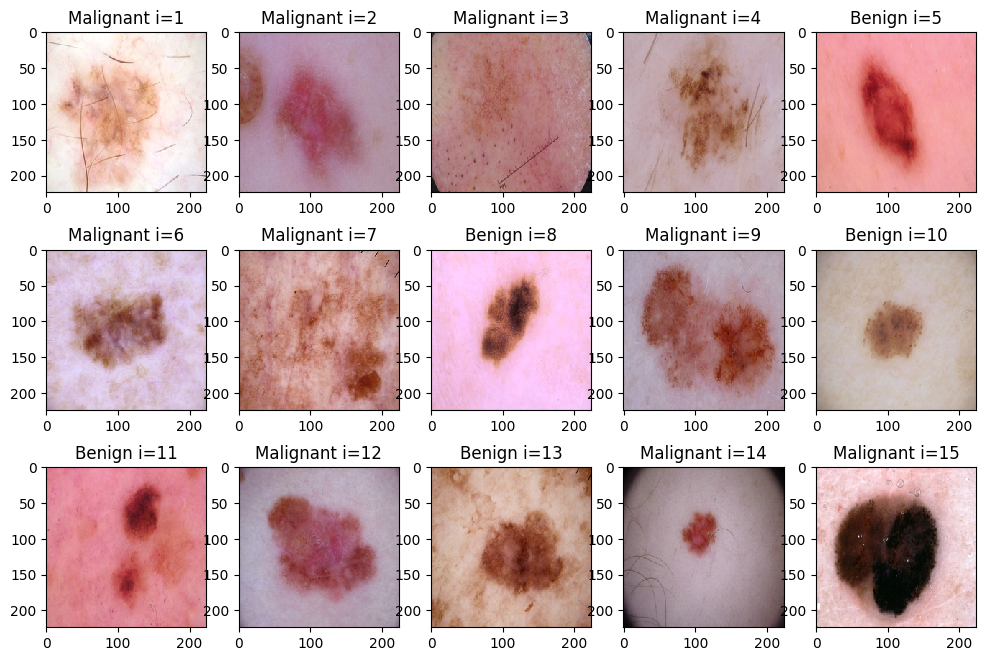

In [16]:
import matplotlib.pyplot as plt

# Display first 15 images of moles, and how they are classified
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign i=' + str(i))
    else:
        ax.title.set_text('Malignant i=' + str(i))
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

# Step 4: Convert data to one-hot encoding and normalize

In [17]:
from keras.utils import to_categorical

y_train = to_categorical(y_train, num_classes= 2)
y_test = to_categorical(y_test, num_classes= 2)

print(y_train.shape)
print(y_test.shape)

# not sure if I need to normalize, but better safe than sorry
X_train = X_train/255.
X_test = X_test/255.

(2625, 2)
(656, 2)


# Alternatively we can fit model on percentage of data


In [18]:
# ## Alternatively we can fit model on percentage of data
# percent = 60
# num_samples = int(X_train.shape[0] * (percent / 100))
# X_train_percent = X_train[:num_samples]
# y_train_percent = y_train[:num_samples]
# print('Shape of X_train_percent:', X_train_percent.shape)
# print('Shape of y_train_percent:', y_train_percent.shape)
# print('Shape of X_train:', X_train.shape)

# Step 5: Model Building 

We will start with a CNN similar to original notebook.
Later we can:
- build something using a ResNet
- experiment with different numbers of Conv 2D filters (compare 32, 64, 128)
- 3x3 pixel window (kernel size) sounds small to me 
    Doctors determine that moles may be malignant (that are also relevant to this model) are
        - Assymetric
        - Irregular borders
        - Variation in color
- ChatGPT thinks that the Conv2D and the first dense layer should be changed ''glorot_uniform' (also known as Xavier uniform initialization) for a ReLU activation function in a convolutional layer is generally not recommended... For ReLU activations, a better weight initialization strategy is often 'he_normal' (He initialization) or 'he_uniform'. These initializers are specifically designed to work well with ReLU units and help prevent issues like the "dying ReLU" problem, where neurons can become inactive during training'
- 

In [19]:
# See learning curve and validation curve

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt

def build(input_shape= (224,224,3), learning_rate = 1e-3, num_classes= 2,
          dense_initializer= 'normal', activ= 'relu', optim= 'adam'):
    model = Sequential()
    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape, #64 is number of filters
                     activation= activ, kernel_initializer='glorot_uniform')) # weights initialized from a uniform distribution within a specific range - good for 
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25)) # a different proportion is 'dropped out' after each forward and backwards pass

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten()) #2D data --> 1D
    model.add(Dense(128, activation='relu', kernel_initializer = dense_initializer)) # 128 neurons – each connected to each neuron in the previous & next layer
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()

    # not sure what these lines do
    if optim == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)

    else:
        optimizer = Adam(learning_rate=learning_rate)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

# Set a learning rate annealer
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', 
                                            patience=5, #patience=5 means the learning rate will be reduced if the validation accuracy does not improve for 5 epochs.
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=1e-7)



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 224, 224, 64)      1792      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 112, 112, 64)      0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 112, 112, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 112, 112, 64)      36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 56, 56, 64)       


Epoch 39: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-06.
dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])


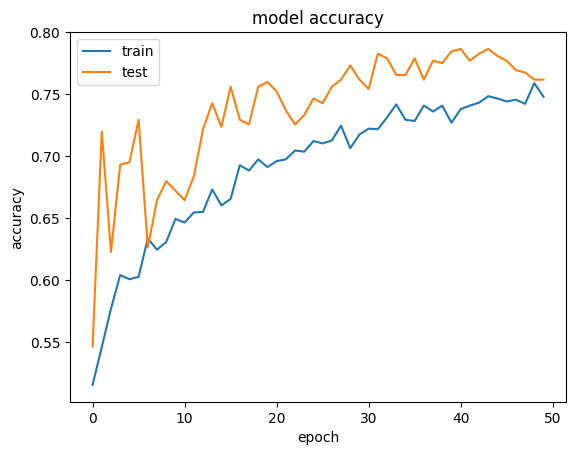

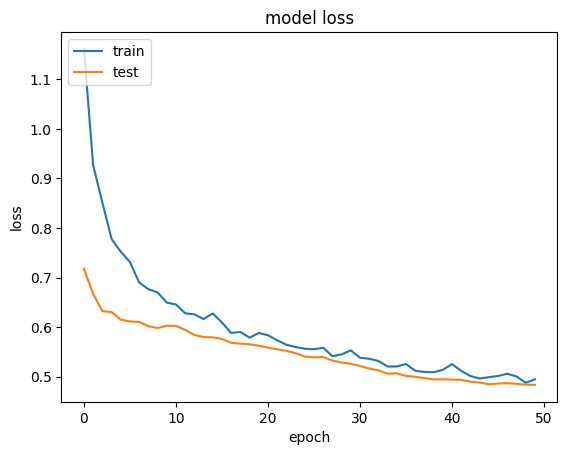

In [20]:
from tensorflow.keras.layers import Layer, InputSpec

model = build(learning_rate=1e-5, dense_initializer= 'normal', activ= 'relu', optim= 'adam', input_shape= (224,224,3))

history = model.fit(X_train, y_train, validation_split=0.2,
                    epochs= 50, batch_size= 64, verbose=0, 
                    callbacks=[learning_rate_reduction]
                   )

# # Alternatively we can fit on a percentage
# history = model.fit(X_train_percent, y_train_percent, validation_split=0.2,
#                     epochs= 50, batch_size= 64, verbose=0, 
#                     callbacks=[learning_rate_reduction]
#                    ) #automatically prints out model summary (below)
                   
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validaton'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# Step 6: Build a Confusion Matrix

21/21 [==============================] - 2s 94ms/step
Confusion Matrix: 
 [[268  92]
 [ 84 212]]


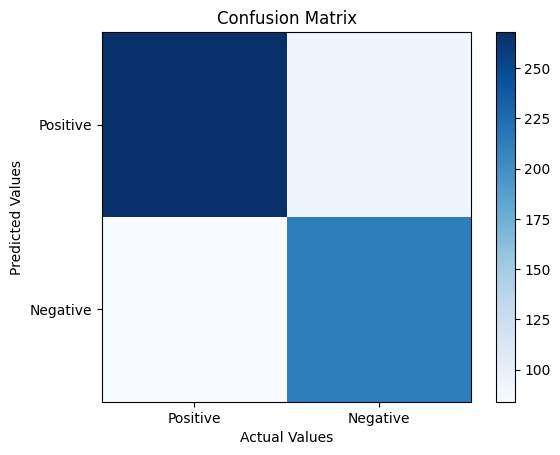

Last validation accuracy: 0.761904776096344
Testing accuracy: 0.7317073170731707


In [43]:
# Cameron added this cell
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Testing model on test data to evaluate
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)  # In this case argmax converts from one-hot encoding to label encoding

# Generate the confusion matrix
cm = confusion_matrix(y_test_labels, y_pred_labels)
print('Confusion Matrix: \n', cm)
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')
plt.show()

print('Last validation accuracy:', history.history['val_accuracy'][-1])
print('Testing accuracy:', (cm[0][0] + cm[1][1]) / (cm[0][0] + cm[0][1] + cm[1][0] + cm[1][1]))

model.save('cam_skincancer_model.h5')


# Step 7: Now We can Try on ResNet50

In [45]:
from keras.applications import ResNet50

input_shape = (224,224,3)
lr = 1e-5
epochs = 50
batch_size = 64

model2 = ResNet50(include_top=True,
                 weights= None,
                 input_tensor=None,
                 input_shape=input_shape,
                 pooling='avg',
                 classes=2)

model2.compile(optimizer = Adam(lr) ,
              loss = "binary_crossentropy", 
              metrics=["accuracy"])

history2 = model2.fit(X_train, y_train, validation_split=0.2,
                    epochs= epochs, batch_size= batch_size, verbose=2, 
                    callbacks=[learning_rate_reduction]
                   )

# list all data in history
print(history2.history.keys())
# summarize history for accuracy
plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()



Epoch 1/50
33/33 - 149s - loss: 0.7532 - accuracy: 0.6795 - val_loss: 0.6896 - val_accuracy: 0.5410 - lr: 1.0000e-05 - 149s/epoch - 5s/step
Epoch 2/50


# Step 8: Build Confusion matrix for ResNet50 and Save Model

In [ ]:
from tensorflow.keras.models import load_model

# Save the model to a file & Load it to make sure it is working
model2.save('cam_skincancer_res_model2.h5')
model2 = load_model('cam_skincancer_res_model2.h5')

# Testing model on test data to evaluate
y_pred2 = model2.predict(X_test)
y_pred_labels2 = np.argmax(y_pred2, axis=1)
y_test_labels = np.argmax(y_test, axis=1)  # In this case argmax converts from one-hot encoding to label encoding

# Generate the confusion matrix
cm2 = confusion_matrix(y_test_labels, y_pred_labels2)
print('Confusion Matrix: \n', cm2)
plt.imshow(cm2, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xticks([0, 1], ['Positive', 'Negative'])
plt.yticks([0, 1], ['Positive', 'Negative'])
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Confusion Matrix')
plt.show()

print('Last validation accuracy:', history2.history['val_accuracy'][-1])
print('Testing accuracy:', (cm2[0][0] + cm2[1][1]) / (cm2[0][0] + cm2[0][1] + cm2[1][0] + cm2[1][1]))